# 1.Import Dependencies

In [1]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Concatenate, Conv2D, ReLU, Dropout, MaxPool2D, BatchNormalization
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
import os
import numpy as np
import tensorflow_addons as tfa
from tensorflow import keras
import sklearn
from sklearn.metrics import classification_report
import tensorflow.keras.backend as kb
import seaborn as sns

# 2.Load Dataset

In [2]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [3]:
BATCH_SIZE = 8
IMG_SIZE = (224, 224)
train_directory = "../input/retinal-fundus-images/Retinal Fundus Images/train"
test_directory = "../input/retinal-fundus-images/Retinal Fundus Images/test"
val_directory = "../input/retinal-fundus-images/Retinal Fundus Images/val"
train_dataset = image_dataset_from_directory(train_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical',
                                             seed=42)
train_dataset = train_dataset.map(process)

validation_dataset = image_dataset_from_directory(test_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical',
                                             seed=42)
validation_dataset = validation_dataset.map(process)

test_dataset = image_dataset_from_directory(val_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode='categorical',
                                             seed=42)
test_dataset = test_dataset.map(process)

Found 20077 files belonging to 11 classes.


2022-07-11 22:52:42.546029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 22:52:42.654073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 22:52:42.654848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 22:52:42.663862: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 1236 files belonging to 11 classes.
Found 433 files belonging to 11 classes.


# 3.Training!

In [4]:
def block_a(inputs):
    
  x1 = Conv2D(128, (1, 1), padding='same')(inputs)
  x1 = Conv2D(128, (3, 3), padding='same')(x1)
  x1 = BatchNormalization(axis=-1)(x1)

  x2 = Conv2D(64, (1, 1), padding='same')(inputs)
  x2 = Conv2D(64, (5, 5), padding='same')(x2)
  x2 = BatchNormalization(axis=-1)(x2)
    
  x3 = Conv2D(128, (1, 1), padding='same')(inputs)
  x3 = Conv2D(32, (7, 7), padding='same')(x3)
  x3 = BatchNormalization(axis=-1)(x3)

  x4 = MaxPool2D(strides=1, padding='same')(inputs)
    
  x = Concatenate()([x1, x2, x3, x4])

  return x

In [5]:
def block_b(inputs):
  
  x1 = Conv2D(64, (1, 1), padding='same')(inputs)
  x1 = Conv2D(64, (3, 3), padding='same')(x1)
  x1 = BatchNormalization(axis=-1)(x1)
    
  x2 = Conv2D(16, (1, 1), padding='same')(inputs)
  x2 = Conv2D(16, (5, 5), padding='same')(x2)
  x2 = BatchNormalization(axis=-1)(x2)

  x3 = Conv2D(8, (1, 1), padding='same')(inputs)
  x3 = Conv2D(8, (7, 7), padding='same')(x3)
  x3 = BatchNormalization(axis=-1)(x3)
    
  x = Concatenate()([x1, x2, x3])

  x = MaxPool2D(padding='valid')(x)
  x = Dropout(0.2)(x)

  return x

In [6]:
def block_c(inputs):
    
  x1 = Conv2D(128, (1, 1), padding='same')(inputs)
  x1 = BatchNormalization(axis=-1)(x1)
    
  x2 = Conv2D(128, (1, 1), padding='same')(inputs)
  x2 = Conv2D(64, (3, 3), padding='same')(x2)
  x2 = BatchNormalization(axis=-1)(x2)

  x3 = Conv2D(128, (1, 1), padding='same')(inputs)
  x3 = Conv2D(32, (5, 5), padding='same')(x3)
  x3 = BatchNormalization(axis=-1)(x3)
    
  x4 = MaxPool2D(strides=1, padding='same')(inputs)

  x = Concatenate()([x1, x2, x3, x4])
  
  return x

In [7]:
def block_d(inputs):
  
  x1 = Conv2D(64, (1, 1), padding='same')(inputs)
  x1 = BatchNormalization(axis=-1)(x1)

  x2 = Conv2D(32, (1, 1), padding='same')(inputs)
  x2 = Conv2D(32, (3, 3), padding='same')(x2)
  x1 = BatchNormalization(axis=-1)(x1)
    
  x3 = Conv2D(16, (1, 1), padding='same')(inputs)
  x3 = Conv2D(16, (5, 5), padding='same')(x3)
  x1 = BatchNormalization(axis=-1)(x1)

  x = Concatenate()([x1, x2, x3])
    
  x = MaxPool2D(padding='valid')(x)
  x = Dropout(0.2)(x)
  
  return x

In [8]:
def classification(pre_trained_model_name : str = None, input_shape: tuple =(224, 224, 3), scratch = False):
  
  if pre_trained_model_name == 'inception':
    pre_trained_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
  
  elif pre_trained_model_name == 'resnet':
    pre_trained_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
  
  elif pre_trained_model_name == 'vgg':
    pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
  
  elif pre_trained_model_name == "densenet":
    pre_trained_model = DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')
    
  if scratch == False and pre_trained_model_name != None:
     for layer in pre_trained_model.layers:
        layer.trainable = False
  
  inputs = tf.keras.Input(shape=input_shape, name='Input')

  if pre_trained_model_name != None:
      x = pre_trained_model(inputs)
      x = block_c(x)
      x = block_d(x)
  else:
    x = block_a(inputs)
    x = block_b(x)
    x = block_a(x)
    x = block_b(x)
    x = block_b(x)
    x = block_c(x)
    x = block_d(x)
    x = block_c(x)
    x = block_d(x)
    x = block_d(x)
    
  x = tfl.Flatten(name='Flatten')(x)
  x = tfl.Dense(11, activation='softmax', name='Output')(x)
  model = tf.keras.Model(inputs=inputs, outputs=x, name=f'Transfer_Learning_by_{pre_trained_model_name}')
  
  return model

In [9]:
model = classification(pre_trained_model_name='vgg')
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "Transfer_Learning_by_vgg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 128)    65664       vgg19[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 128)    65664       vgg19[0][0]                      
__________

In [10]:
base_learning_rate = 0.01
checkpoint_filepath = '/kaggle/working/tmp/models/vgg_c_d_11D'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_F1 Score')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(11, average='macro', threshold=0.5, name='F1 Score')])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=15, callbacks=model_checkpoint_callback)

Epoch 1/15


2022-07-11 22:52:46.870323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-11 22:52:50.144189: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2510/2510 [==============================] - 146s 54ms/step - loss: 12.9395 - accuracy: 0.5393 - precision: 0.5416 - recall: 0.5379 - F1 Score: 0.5095 - val_loss: 29.7596 - val_accuracy: 0.5882 - val_precision: 0.5883 - val_recall: 0.5874 - val_F1 Score: 0.4590


2022-07-11 22:55:14.805438: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/15
2510/2510 [==============================] - 98s 39ms/step - loss: 18.1785 - accuracy: 0.6310 - precision: 0.6311 - recall: 0.6310 - F1 Score: 0.6238 - val_loss: 16.9290 - val_accuracy: 0.6383 - val_precision: 0.6394 - val_recall: 0.6383 - val_F1 Score: 0.5695
Epoch 3/15
2510/2510 [==============================] - 98s 39ms/step - loss: 21.2322 - accuracy: 0.6586 - precision: 0.6586 - recall: 0.6586 - F1 Score: 0.6565 - val_loss: 26.2147 - val_accuracy: 0.6359 - val_precision: 0.6359 - val_recall: 0.6359 - val_F1 Score: 0.6059
Epoch 4/15
2510/2510 [==============================] - 98s 39ms/step - loss: 22.3387 - accuracy: 0.6779 - precision: 0.6779 - recall: 0.6778 - F1 Score: 0.6836 - val_loss: 47.6618 - val_accuracy: 0.5817 - val_precision: 0.5817 - val_recall: 0.5817 - val_F1 Score: 0.5780
Epoch 5/15
2510/2510 [==============================] - 99s 39ms/step - loss: 21.9563 - accuracy: 0.6998 - precision: 0.6998 - recall: 0.6998 - F1 Score: 0.7114 - val_loss: 46.7894 - v

# 4.Fine Tunning

In [12]:
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "Transfer_Learning_by_vgg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, 7, 7, 512)    20024384    Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 128)    65664       vgg19[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 128)    65664       vgg19[0][0]                      
___________________________________________________________________________

In [13]:
base_learning_rate = 0.00001
checkpoint_filepath = '/kaggle/working/tmp/models/vgg_c_d_11D'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_F1 Score')
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(11, average='macro', threshold=0.5, name='F1 Score')])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
history1 = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=model_checkpoint_callback)

Epoch 1/10
2510/2510 [==============================] - 236s 93ms/step - loss: 34.7156 - accuracy: 0.7221 - precision_1: 0.7221 - recall_1: 0.7221 - F1 Score: 0.7278 - val_loss: 46.9510 - val_accuracy: 0.6853 - val_precision_1: 0.6853 - val_recall_1: 0.6853 - val_F1 Score: 0.6746
Epoch 2/10
2510/2510 [==============================] - 232s 93ms/step - loss: 19.0823 - accuracy: 0.7566 - precision_1: 0.7566 - recall_1: 0.7566 - F1 Score: 0.7772 - val_loss: 27.7216 - val_accuracy: 0.7621 - val_precision_1: 0.7621 - val_recall_1: 0.7621 - val_F1 Score: 0.7350
Epoch 3/10
2510/2510 [==============================] - 232s 92ms/step - loss: 13.5601 - accuracy: 0.7810 - precision_1: 0.7810 - recall_1: 0.7810 - F1 Score: 0.8023 - val_loss: 18.4423 - val_accuracy: 0.7508 - val_precision_1: 0.7508 - val_recall_1: 0.7508 - val_F1 Score: 0.7511
Epoch 4/10
2510/2510 [==============================] - 231s 92ms/step - loss: 10.2709 - accuracy: 0.7959 - precision_1: 0.7959 - recall_1: 0.7959 - F1 Score

# 5.Evaluation

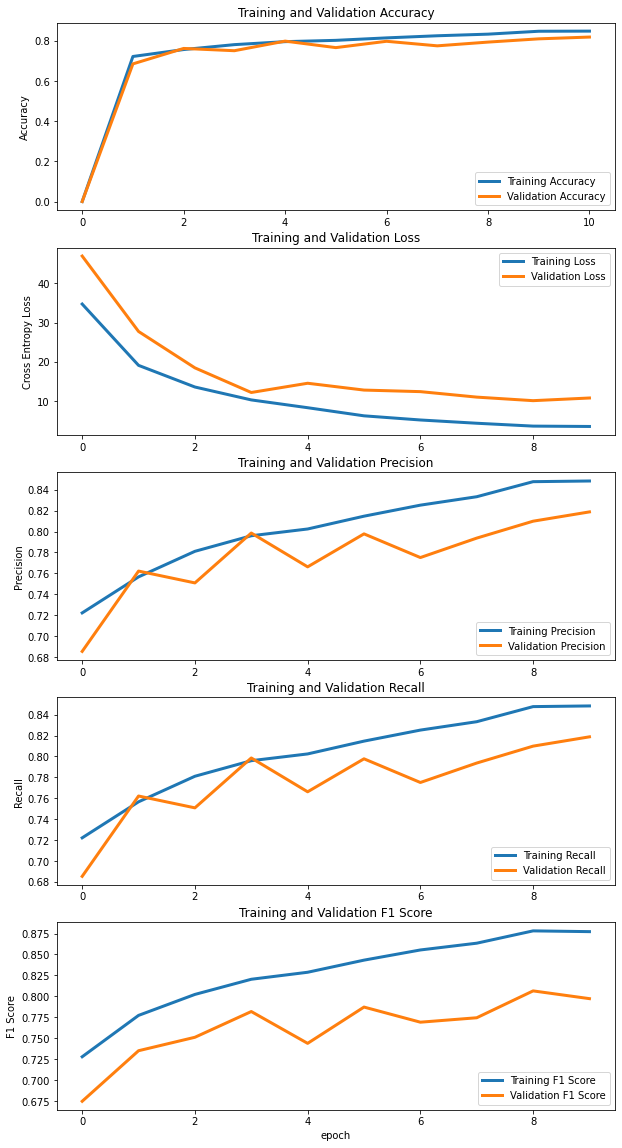

In [15]:
acc = [0.] + history1.history['accuracy']
val_acc = [0.] + history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

f1 = history1.history['F1 Score']
f1_val = history1.history['val_F1 Score']

precision = history1.history['precision_1']
precision_val = history1.history['val_precision_1']

recall = history1.history['recall_1']
recall_val = history1.history['val_recall_1']

fig = plt.figure(figsize=(10, 20))
plt.subplot(5, 1, 1)
plt.plot(acc, label='Training Accuracy', linewidth=3)
plt.plot(val_acc, label='Validation Accuracy', linewidth=3)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(5, 1, 2)
plt.plot(loss, label='Training Loss', linewidth=3)
plt.plot(val_loss, label='Validation Loss', linewidth=3)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')

plt.subplot(5, 1, 3)
plt.plot(precision, label='Training Precision', linewidth=3)
plt.plot(precision_val, label='Validation Precision', linewidth=3)
plt.legend(loc='lower right')
plt.ylabel('Precision')
#plt.ylim([0,1.0])
plt.title('Training and Validation Precision')

plt.subplot(5, 1, 4)
plt.plot(recall, label='Training Recall', linewidth=3)
plt.plot(recall_val, label='Validation Recall', linewidth=3)
plt.legend(loc='lower right')
plt.ylabel('Recall')
#plt.ylim([0,1.0])
plt.title('Training and Validation Recall')


plt.subplot(5, 1, 5)
plt.plot(f1, label='Training F1 Score', linewidth=3)
plt.plot(f1_val, label='Validation F1 Score', linewidth=3)
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation F1 Score')
plt.xlabel('epoch')
plt.show()
fig.savefig("plt1_vgg_c_d_11D_1.jpg", format='jpg', dpi=600)

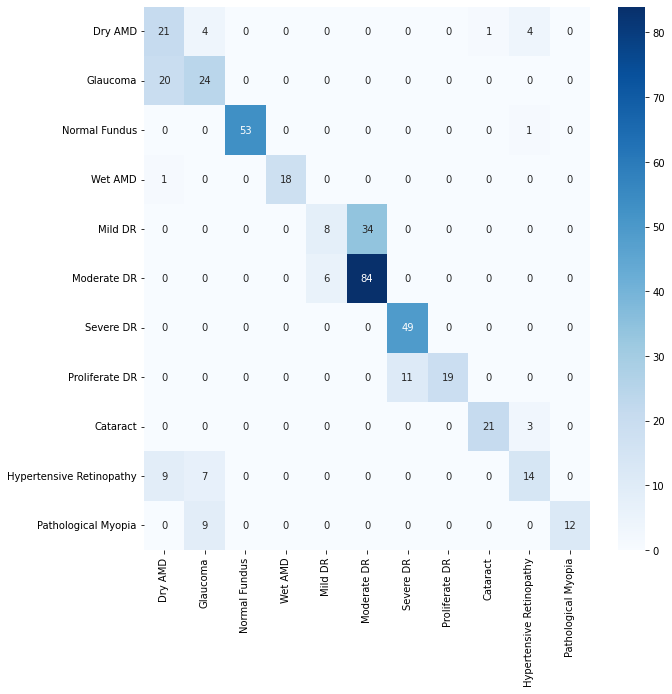

In [16]:
test_preds = []
test_labels = []
columns = ['Dry AMD', 'Glaucoma', "Normal Fundus", "Wet AMD", "Mild DR", "Moderate DR", "Severe DR", "Proliferate DR", "Cataract", "Hypertensive Retinopathy", "Pathological Myopia"]
for images, labels in test_dataset.take(-1):
  array_labels = np.array(labels)
  array_labels = np.where(array_labels == 1)[1]
  for ii in range(array_labels.shape[0]):
    test_labels.append(array_labels[ii])
    test_preds.append(np.argmax(np.array(model.predict(tf.expand_dims(images[ii], 0)))))
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)
cm = np.zeros((11, 11))
for i in range(433):
  cm[test_labels[i]][test_preds[i]] = cm[test_labels[i]][test_preds[i]] + 1
plt.figure(figsize=(10, 10))
cf_matrix = pd.DataFrame(cm, columns=columns, index=columns)
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
plt.savefig("cm_vgg_c_d_11D.jpg", format='jpg', dpi=600)

In [17]:
!zip -r densenet_c_d_11D.zip "./tmp/models/vgg_c_d_11D"

  adding: tmp/models/vgg_c_d_11D/ (stored 0%)
  adding: tmp/models/vgg_c_d_11D/variables/ (stored 0%)
  adding: tmp/models/vgg_c_d_11D/variables/variables.index (deflated 77%)
  adding: tmp/models/vgg_c_d_11D/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: tmp/models/vgg_c_d_11D/saved_model.pb (deflated 90%)
  adding: tmp/models/vgg_c_d_11D/keras_metadata.pb (deflated 95%)
  adding: tmp/models/vgg_c_d_11D/assets/ (stored 0%)


In [18]:
from pathlib import Path
cr = sklearn.metrics.classification_report(test_labels, test_preds, target_names=columns, output_dict=True)
filepath = Path('cr_vgg_c_d_11D.csv')
pd.DataFrame(cr).transpose().to_csv(filepath)